In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.graves import graves_new as graves

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
GRAVES_MODEL_PATH = "/media/thorsteinngj/c1f0e49d-1218-4d11-ab9f-aadb4a021648/home/thorsteinngj/Documents/Thesis/logs/more_data_used/mask_rcnn_graves_0032.h5"  # TODO: update this path

In [3]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
config = graves.CustomConfig()
GRAVES_DIR = os.path.join(ROOT_DIR, "samples/graves")

In [4]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE     

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [8]:
# Load validation dataset
dataset = graves.CustomDataset()
dataset.load_custom("/home/thorsteinngj/Documents/Skoli/Thesis/Code/Mask_RCNN/samples/graves/dataset_g/","val")
#dataset.load_custom("/media/thorsteinngj/c1f0e49d-1218-4d11-ab9f-aadb4a021648/home/thorsteinngj/Documents/Thesis/pics/")
#dataset.load_custom(BALLOON_DIR, "/dataset/val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 217
Classes: ['BG', 'angel', 'bible', 'cross', 'david', 'dove', 'person', 'praying']


In [10]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
if config.NAME == "graves":
    weights_path = GRAVES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading weights  /media/thorsteinngj/c1f0e49d-1218-4d11-ab9f-aadb4a021648/home/thorsteinngj/Documents/Thesis/logs/more_data_used/mask_rcnn_graves_0032.h5


### Evaluation of class-level accuracy
Here I evaluate roughly how the well each class is being recognized.

In [11]:
# Just simply checking if we're getting anything close from the checks.
def compute_batch_ap(image_ids):
    classes = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        data = {'True classes': gt_class_id,'Detected classes':r['class_ids'],'True mask':gt_mask,'Found_mask':r['masks'],'image':image_id}
        classes.append(data)
    return classes

# Pick a set of random images
#image_ids = np.random.choice(dataset.image_ids, 68)
image_ids = dataset.image_ids
classes_all = compute_batch_ap(image_ids)
#print("mAP @ IoU=50: ", np.mean(APs))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216


In [15]:
for i in range(len(classes_all)):
    print('Image number '+str(i))
    print(classes_all[i]['True classes'])
    print(classes_all[i]['Detected classes'])

Image number 0
[5 3]
[3]
Image number 1
[5]
[5]
Image number 2
[5]
[5]
Image number 3
[5 5]
[5 5]
Image number 4
[5 2]
[2 7]
Image number 5
[5]
[5]
Image number 6
[5 5 7 7]
[7 7]
Image number 7
[5 5]
[5 5]
Image number 8
[7 7 3]
[3 7 7]
Image number 9
[2 7 2]
[7 2 2]
Image number 10
[2 7 2]
[2 2 7]
Image number 11
[7]
[7]
Image number 12
[7]
[7 3]
Image number 13
[7 3]
[7]
Image number 14
[2 2 7]
[2 2 7]
Image number 15
[7]
[7]
Image number 16
[3 7]
[3]
Image number 17
[7]
[7]
Image number 18
[7]
[7]
Image number 19
[7]
[7]
Image number 20
[3 7 2]
[7 2 3]
Image number 21
[3 7 3 7]
[3 3]
Image number 22
[7]
[]
Image number 23
[1 7]
[5 7]
Image number 24
[7]
[7]
Image number 25
[7]
[7]
Image number 26
[2 7 2]
[2 7]
Image number 27
[7 2]
[2 7]
Image number 28
[7]
[7]
Image number 29
[7 7]
[7 7]
Image number 30
[7 3]
[3 7]
Image number 31
[3 3 2 7 2]
[3 3 2 7 2]
Image number 32
[7]
[7]
Image number 33
[3 3 7]
[3 7 3]
Image number 34
[3 3 7]
[7 3 3]
Image number 35
[7 3 2 3 7]
[7 2 3 3 7 1 

In [32]:
x

Counter({1: 2, 2: 3, 3: 5, 4: 3, 5: 1, 7: 2})

In [28]:
y

Counter({1: 36, 2: 92, 3: 106, 4: 19, 5: 27, 6: 15, 7: 67})

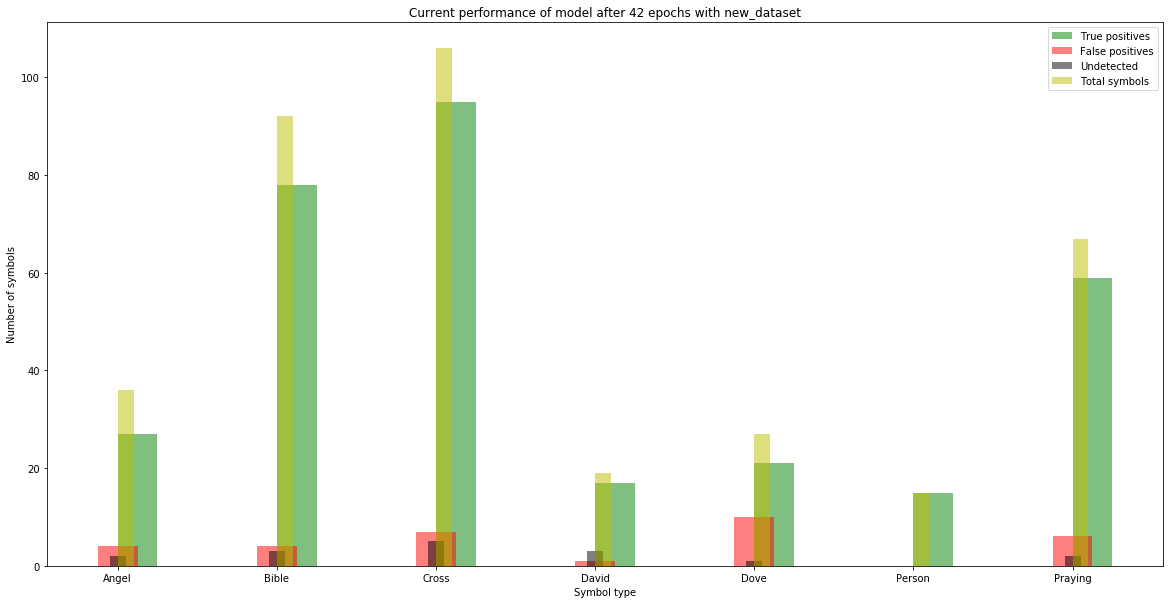

In [24]:
import numpy as np
from collections import Counter
#len(classes_all[2]['Detected classes'])


true_numbers = []
false_numbers = []

for i in range(len(classes_all)):
    for j in range(len(classes_all[i]['True classes'])):
        if (np.size(classes_all[i]['True classes']) > 0):
            true_numbers.append(classes_all[i]['True classes'][j])
    for k in range(len(classes_all[i]['Detected classes'])):
        if (np.size(classes_all[i]['Detected classes']) > 0):
            false_numbers.append(classes_all[i]['Detected classes'][k])
            
true_pos = []
false_pos = []
undetected = []

from collections import Counter
import matplotlib.pyplot as plt

for i in range(len(classes_all)):
    if (np.size(classes_all[i]['Detected classes']) > 0):
        for k in range(len(classes_all[i]['Detected classes'])):
            if classes_all[i]['Detected classes'][k] in classes_all[i]['True classes']:
                true_pos.append(classes_all[i]['Detected classes'][k])
            else:
                false_pos.append(classes_all[i]['Detected classes'][k])
    else:
        if (np.size(classes_all[i]['True classes']) > 0):
            for k in range(len(classes_all[i]['True classes'])):
                undetected.append(classes_all[i]['True classes'][k])

w = Counter(true_pos)
z = Counter(false_pos)
x = Counter(undetected)
y = Counter(true_numbers)

plt.figure(figsize=(20,10))
plt.title('Current performance of model after 42 epochs with new_dataset')
plt.bar(w.keys(), w.values(),label='True positives',alpha=0.5,color='g',align='edge',width=0.25)
plt.bar(z.keys(), z.values(),label='False positives',alpha=0.5,color='r',width=0.25)
plt.bar(x.keys(), x.values(),label='Undetected',alpha=0.5,color='k',width=0.1)
plt.bar(y.keys(), y.values(),label='Total symbols',alpha=0.5,color='y',width=0.1,align='edge')
plt.ylabel('Number of symbols')
#plt.xticks(np.arange(1,8), ('Cross', 'Bible', 'Praying', 'Rings', 'God','Jesus','Other'))
plt.xticks(np.arange(1,8), ('Angel', 'Bible', 'Cross', 'David', 'Dove','Person','Praying'))
plt.xlabel('Symbol type')
plt.legend()
plt.show()

In [36]:
false_pos

[3,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 7,
 1,
 7,
 5,
 5,
 1,
 1,
 1,
 3,
 1,
 3]

In [25]:
for i in range(len(classes_all)):
    if (np.size(classes_all[i]['Detected classes']) > 0):
        for k in range(len(classes_all[i]['Detected classes'])):
            if classes_all[i]['Detected classes'][k] in classes_all[i]['True classes']:
                true_pos.append(classes_all[i]['Detected classes'][k])
            else:
                false_pos.append(classes_all[i]['Detected classes'][k])
    else:
        if (np.size(classes_all[i]['True classes']) > 0):
            for k in range(len(classes_all[i]['True classes'])):
                undetected.append(classes_all[i]['True classes'][k])

In [53]:
true_pos

[3,
 3,
 3,
 7,
 7,
 2,
 7,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6]

In [26]:
from collections import Counter
import matplotlib.pyplot as plt

w = Counter(true_pos)
z = Counter(false_pos)
x = Counter(undetected)
y = Counter(true_numbers)

In [27]:
w+x+z

Counter({1: 26, 2: 27, 3: 19, 4: 6, 5: 11, 6: 12, 7: 13})

In [28]:
y

Counter({1: 9, 2: 18, 3: 24, 4: 7, 5: 19, 6: 12, 7: 17})

IndexError: list index out of range

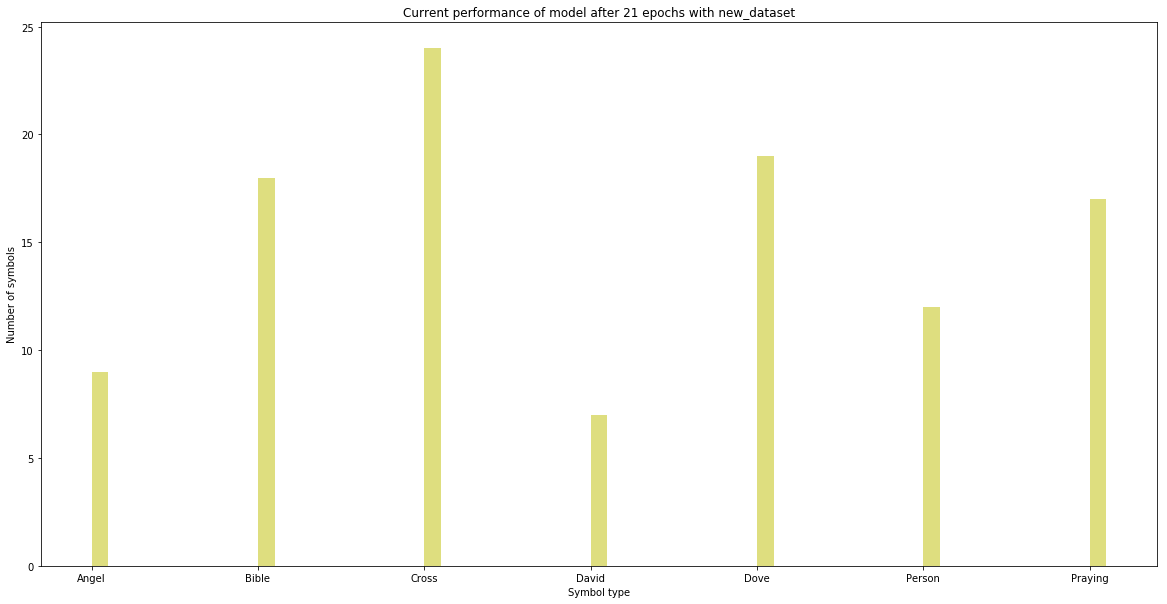

In [34]:
plt.figure(figsize=(20,10))
plt.title('Current performance of model after 21 epochs with new_dataset')
plt.bar(w.keys(), w.values(),label='True positives',alpha=0.5,color='g',align='edge',width=0.25)
plt.bar(z.keys(), z.values(),label='False positives',alpha=0.5,color='r',width=0.25)
plt.bar(x.keys(), x.values(),label='Undetected',alpha=0.5,color='k',width=0.1)
plt.bar(y.keys(), y.values(),label='Total true',alpha=0.5,color='y',width=0.1,align='edge')
plt.ylabel('Number of symbols')
#plt.xticks(np.arange(1,8), ('Cross', 'Bible', 'Praying', 'Rings', 'God','Jesus','Other'))
plt.xticks(np.arange(1,8), ('Angel', 'Bible', 'Cross', 'David', 'Dove','Person','Praying'))
plt.xlabel('Symbol type')
plt.legend()
plt.show()

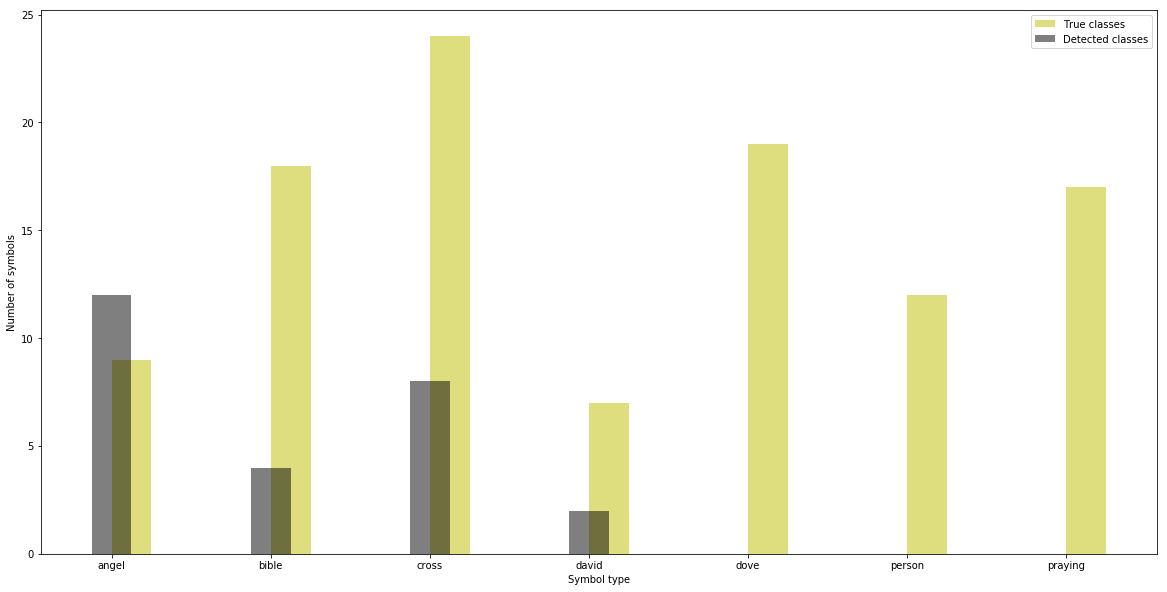

In [68]:
from collections import Counter
import matplotlib.pyplot as plt

w = Counter(true_numbers)
z = Counter(false_numbers)

def key_changer(counter):
    for i in range(len(counter.keys())):
        try:
            counter['angel'] = counter.pop(i+1)
            counter['bible'] = counter.pop(i+2)
            counter['cross'] = counter.pop(i+3)
            counter['david'] = counter.pop(i+4)
            counter['dove'] = counter.pop(i+5)
            counter['person'] = counter.pop(i+6)
            counter['praying'] = counter.pop(i+7)
        except KeyError:
            continue
    return counter




w_new = key_changer(w)
z_new = key_changer(z)


indices = range(len(w_new))
width = np.min(np.diff(indices))/3.

#Still need to figure how to but the bars next to each other, and how to check for each respective stuff.

plt.figure(figsize=(20,10))
plt.bar(w.keys(), w.values(),label='True classes',alpha=0.5,color='y',align='edge',width=0.25)
plt.bar(z.keys(), z.values(),label='Detected classes',alpha=0.5,color='k',width=0.25)
plt.ylabel('Number of symbols')
plt.xlabel('Symbol type')
plt.legend()
plt.show()


In [11]:
w = Counter(true_numbers)
w

Counter({1: 98, 2: 51, 3: 22, 4: 22, 5: 2})

In [12]:
def key_changer(counter):
    for i in range(len(counter.keys())):
        try:
            counter['cross'] = counter.pop(i+1)
            counter['bible'] = counter.pop(i+2)
            counter['praying'] = counter.pop(i+3)
            counter['rings'] = counter.pop(i+4)
            counter['god'] = counter.pop(i+5)
            counter['jesus'] = counter.pop(i+6)
        except KeyError:
            continue
    return counter


In [13]:
def key_changer(counter):
    if counter:
        counter['cross'] = counter.pop(1)
        counter['bible'] = counter.pop(2)
        counter['praying'] = counter.pop(3)
        counter['rings'] = counter.pop(4)
        counter['god'] = counter.pop(5)
        counter['jesus'] = counter.pop(6)
    if len(counter) >4:
        try:
            counter['cross'] = counter.pop(1)
            counter['bible'] = counter.pop(2)
            counter['praying'] = counter.pop(3)
            counter['rings'] = counter.pop(4)
            #counter['god'] = counter.pop(5)
            counter['jesus'] = counter.pop(6)
        else:
            counter['cross'] = counter.pop(1)
            counter['bible'] = counter.pop(2)
            counter['praying'] = counter.pop(3)
            counter['rings'] = counter.pop(4)
    return counter

SyntaxError: invalid syntax (<ipython-input-13-e628687770d9>, line 17)

In [ ]:
z